参考：https://github.com/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_5_階層ベイズモデル.ipynb

pymc3ではnumpyroを使えず、最新のpymcをインストールする必要があった。

pymc用の仮想環境を作成した

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

sns.set_context('talk', font_scale=0.8)

データの作成

In [2]:
np.random.seed(12)
group_num = 9
data_num = 25

a_vector = np.random.normal(1000.0, scale=100.0, size=group_num)
b_vector = np.random.normal(50000.0, scale=500.0, size=group_num)

x_data = np.random.uniform(20, 50, data_num)

group_idx = np.random.randint(0, group_num, data_num)
y_data = a_vector[group_idx] * x_data + b_vector[group_idx] + np.random.normal(0, scale=1500.0, size=data_num)

x_data = np.append(x_data, 33.322)
y_data = np.append(y_data, 75004.54)
group_idx = np.append(group_idx, 8)

# # データ読み込み
#df_data = pd.read_csv('toy_data.csv')
# # 真の係数パラメータデータ
#df_coef = pd.read_csv('true_corf.csv')

df_data = pd.DataFrame([x_data, y_data, group_idx]).T
df_data.columns = ['x', 'y', 'systemID']

df_coef = pd.DataFrame([a_vector, b_vector]).T
df_coef.columns = ['a', 'b']

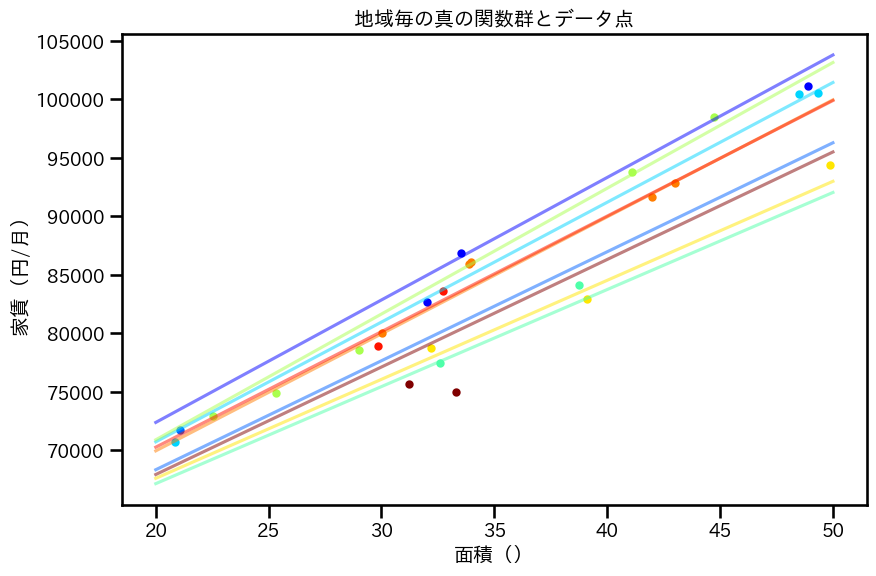

In [3]:
# 説明変数
x_data = df_data['x'].values
# 目的変数
y_data = df_data['y'].values
# 地域グループ
group_idx = df_data['systemID'].values.astype(int)
# 地域毎の傾きとバイアス
a_vector, b_vector = df_coef['a'].values, df_coef['b'].values

# 可視化用
x_linspace = np.linspace(20, 50, 100)

fig, ax = plt.subplots(figsize=(9, 6))
cm10 = plt.get_cmap('jet', 10)
for i in range(9):
  # 真の関数可視化
  ax.plot(x_linspace, a_vector[i]*x_linspace+b_vector[i], color=cm10(i+1), alpha=0.5)
  # 学習データ可視化
  ax.scatter(x_data[group_idx==i], y_data[group_idx==i], marker='.', color=cm10(i+1))

ax.set_xlabel('面積（）');ax.set_ylabel('家賃（円/月）')
ax.set_title('地域毎の真の関数群とデータ点')
plt.tight_layout()

地域ごとに線形回帰を実施

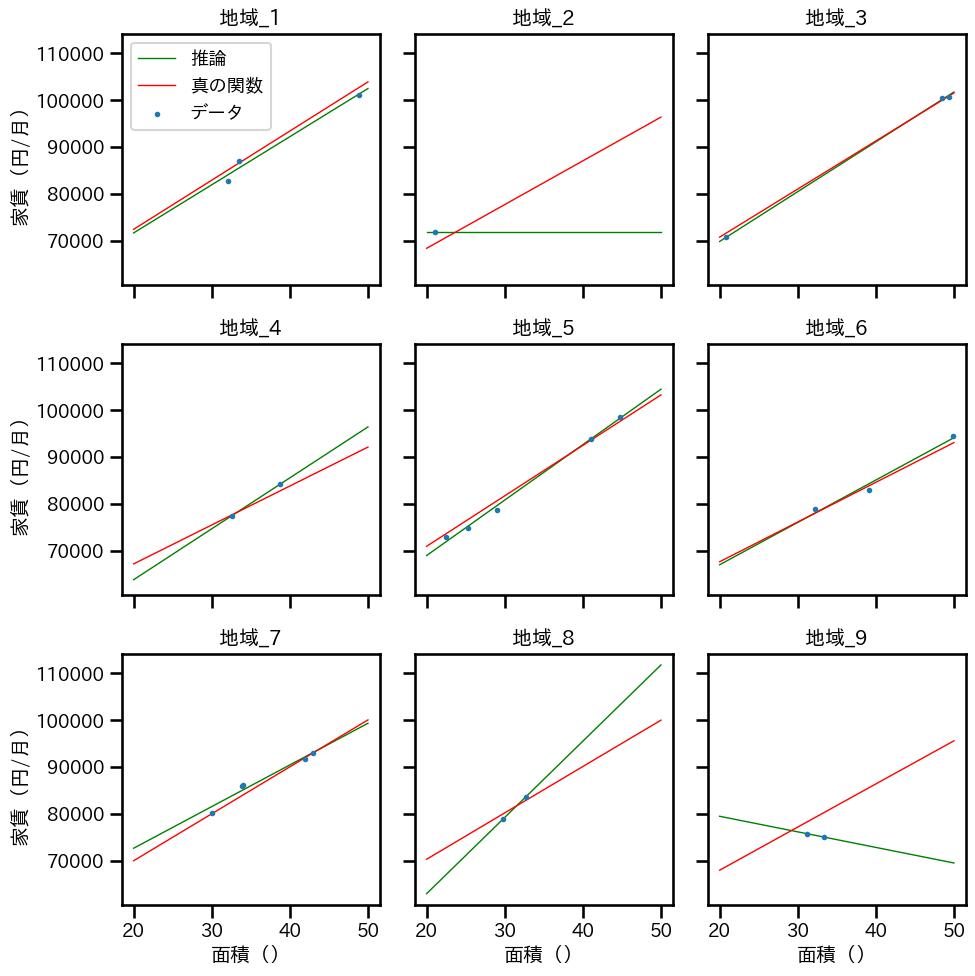

In [4]:

from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域グループ毎に処理
for i in range(9):
  row_index = i//3
  col_index  = i%3

  # 地域グループ取り出し
  x_i = x_data[group_idx==i]
  y_i = y_data[group_idx==i]
  # 線形回帰
  lr = LinearRegression()
  lr.fit(x_i.reshape(-1,1), y_i.reshape(-1,1))            

    # 線形回帰可視化
  y_linear_model = lr.predict(x_new.reshape(-1,1))
  ax[row_index, col_index].plot(x_new, y_linear_model, color = 'green',\
  linewidth = 1, label='推論')
  # 真の関数可視化
  y_true = a_vector[i]*x_new+b_vector[i]
  ax[row_index, col_index].plot(x_new, y_true, color = 'red',\
  linewidth = 1, label='真の関数')
  # 学習データ可視化
  ax[row_index, col_index].scatter(x_i, y_i, marker='.', s=25,\
  zorder=2, label='データ')
  
  ax[row_index, col_index].set_title('地域_{}'.format(i+1))  
  if row_index==2:
    ax[row_index, col_index].set_xlabel('面積（）')
  if col_index==0:
    ax[row_index, col_index].set_ylabel('家賃（円/月）')
 
ax[0,0].legend()
plt.tight_layout()

階層ベイズモデル

In [5]:
import pymc as pm

# モデルの定義
with pm.Model() as model:

    # 説明変数
    X_shared = pm.Data("x", x_data)

    # 傾きについてのハイパーパラメータの事前分布
    a_mu = pm.Normal('a_mu', mu=50.0, sigma=10.0)
    a_sigma = pm.HalfCauchy('a_sigma', beta=100.0)

    # 地域毎の傾き
    a_offset = pm.Normal('a_offset', mu=a_mu, sigma=a_sigma, shape=group_num)

    # バイアスについてのハイパーパラメータの事前分布
    b_mu = pm.Normal('b_mu', mu=50000.0, sigma=1000.0)
    b_sigma = pm.HalfCauchy('b_sigma', beta=1000.0)
    
    # 地域毎のバイアス
    b_offset = pm.Normal('b_offset', mu=b_mu, sigma=b_sigma, shape=group_num)

    # 尤度関数
    y = pm.Normal('y', mu=a_offset[group_idx]*X_shared + b_offset[group_idx], sigma=1000, observed=y_data)


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [7]:
with model:
    # MCMCによる推論
    trace = pm.sample(
                    draws=3000, 
                    tune=1000, 
                    nuts_sampler="numpyro",
                    chains=3, 
                    random_seed=1, 
                    return_inferencedata=True)

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:03.827963
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 2271.22it/s] 


Sampling time =  0:00:02.216269
Transforming variables...
Transformation time =  0:00:00.013728


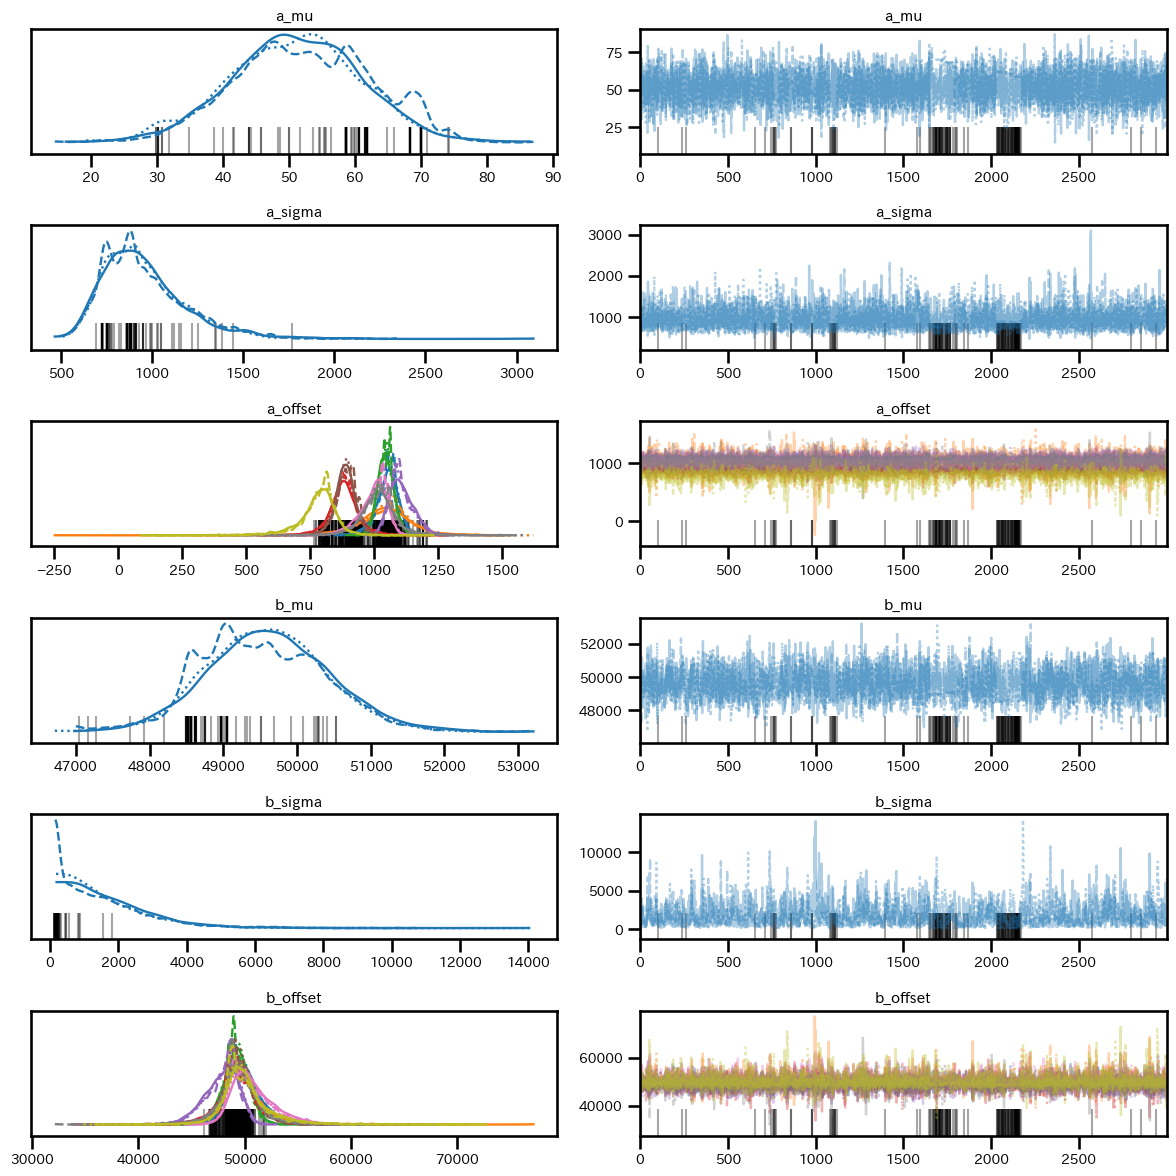

In [8]:
az.plot_trace(trace, var_names=['a_mu', 'a_sigma', 'a_offset', 'b_mu', 'b_sigma', 'b_offset']);
plt.tight_layout();
     

In [9]:

for var_info in az.rhat(trace).values():
  print(var_info.name, var_info.values.round(3))

a_mu 1.007
a_offset [1.002 1.003 1.001 1.004 1.007 1.007 1.007 1.002 1.002]
b_mu 1.007
b_offset [1.006 1.004 1.001 1.004 1.005 1.003 1.01  1.002 1.002]
a_sigma 1.001
b_sigma 1.03


In [10]:
trace.posterior['a_offset'].shape

(3, 3000, 9)

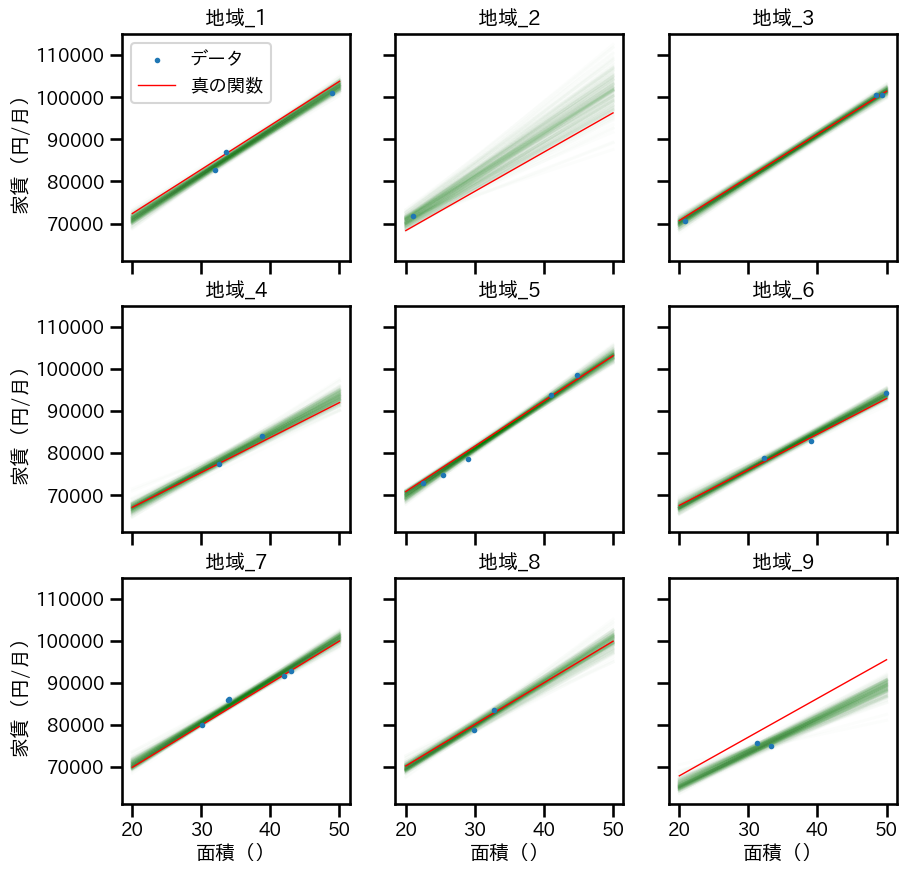

In [11]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域グループ毎に処理
for i in range(9):
  row_index = i//3
  col_index  = i%3

  # 地域ごとの係数パラメータのMCMCサンプル平均値と標準偏差を算出
  a_i_mcmc_samples = trace.posterior['a_offset'][0, :, i]
  b_i_mcmc_samples = trace.posterior['b_offset'][0, :, i]
  
  # 学習データ可視化
  x_i = x_data[group_idx==i]
  y_i = y_data[group_idx==i]
  ax[row_index, col_index].scatter(x_i, y_i, marker='.', zorder=3, s=25, label='データ')
  
  # MCMCサンプルを使って予測分布の平均を可視化
  for k in range(0, 3000, 15):
    y_new_sample = a_i_mcmc_samples[k].values * x_new + b_i_mcmc_samples[k].values
    ax[row_index, col_index].plot(x_new, y_new_sample, alpha=0.01, color ='green', zorder=1)
    
  # 真の関数可視化
  y_true = a_vector[i]*x_new+b_vector[i]
  ax[row_index, col_index].plot(x_new, y_true, color = 'red',\
  linewidth = 1, label='真の関数')
  
  ax[row_index, col_index].set_title('地域_{}'.format(i+1))
  if row_index==2:
    ax[row_index, col_index].set_xlabel('面積（）')
  if col_index==0:
    ax[row_index, col_index].set_ylabel('家賃（円/月）')
ax[0, 0].legend();